In [1]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [2]:


import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_ckpt_path 
from src.select_outputs_on_params import select_outputs_on_params
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import re
from src.utils import *


In [3]:
plt.style.use('ggplot')

In [4]:
cmap = plt.get_cmap('viridis')

In [5]:
gpu = 1
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Initializing datamodule


In [7]:
save_fig = False

In [8]:
load_pca = True

In [9]:
norm = False

In [10]:
with open(f"pickle/rmse_ssp_pca_on_dm_3D_norm_False.pkl", "rb") as file:
    old_pca_rmse_dict = pickle.load(file)  

In [11]:
if load_pca:
    with open(f"pickle/rmse_pca_all_components_with_pooling_upsampling_norm_{norm}_sklearn_pca.pkl", "rb") as file:
        pca_rmse_dict = pickle.load(file)  
        
else:
    pca_rmse_dict = {}
    

In [12]:
pca_n_layers = 5 #Number of layers to keep for the PCA


# Functions

In [13]:
# def explicit_ecs_1D(ssp: torch.tensor,
#                     depth_tens: torch.tensor,
#                     tau = 100):
    
#     ssp = ssp.unsqueeze(1).nan_to_num()          # This operation might be unnecessary if ssp already has the correct shape
#     kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2).to(ssp.device)
#     derivative = F.conv1d(ssp, kernel, padding=0)

#     sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

#     sign_diff = F.conv1d(sign, kernel, padding=1)
#     sign_change = F.tanh(10 * F.relu(-sign_diff))

#     for pattern in ([1, 0, 1], [1, -1, 0, 0]):
#         n = len(pattern)
#         kernel_matrix = torch.eye(n)
#         element_match = 0
#         for i in range(n):
#             kernel_element = kernel_matrix[i, :].view(1, 1, n).to(ssp.device)
#             element_match += (F.conv1d(sign, kernel_element, padding=0) - pattern[i]) ** 2

#         # Adjust padding to match the length of sign_change
#         pattern_recognition = F.pad(element_match, (1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
#         mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

#         sign_change = sign_change * mask_discontinuity

#     mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

#     # Expand and align depth_array with the reduced shape of the input tensor
     
#     depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1).to(ssp.device).type(sign_change.dtype)
#     depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

#     ecs_pred = (sign_change * mask).squeeze(dim=1)
#     ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
#     return ecs_pred



In [14]:
# def explicit_ecs_2D(ssp: torch.tensor,
#                     depth_tens: torch.tensor,
#                     batch: bool = False,
#                     tau = 100):
    
#     if batch:
#         ssp = ssp.unsqueeze(1).nan_to_num()  
    
#     else:
#         ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()  
        
#     kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2, 1).to(ssp.device)
#     derivative = F.conv2d(ssp, kernel, padding=0)

#     sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

#     sign_diff = F.conv2d(sign, kernel, padding=(1,0))
#     sign_change = F.tanh(10 * F.relu(-sign_diff))

#     for pattern in ([1, 0, 1], [1, -1, 0, 0]):
#         n = len(pattern)
#         kernel_matrix = torch.eye(n)
#         element_match = 0
#         for i in range(n):
#             kernel_element = kernel_matrix[i, :].view(1, 1, n, 1).to(ssp.device)
#             element_match += (F.conv2d(sign, kernel_element, padding=0) - pattern[i]) ** 2

#         # Adjust padding to match the length of sign_change
#         pattern_recognition = F.pad(element_match, (0,0,1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
#         mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

#         sign_change = sign_change * mask_discontinuity

#     mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

#     # Expand and align depth_array with the reduced shape of the input tensor
     
#     depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1, 1).to(ssp.device).type(sign_change.dtype)
#     depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

#     ecs_pred = (sign_change * mask).squeeze(dim=1)
#     ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
    
#     if not batch:
#         ecs_pred = ecs_pred.squeeze(0)
        
#     return ecs_pred

# #ecs_2d = explicit_ecs_2D(torch.tensor(ssp_truth_unorm_test_arr[t,:,lat,:]).float(),torch.tensor(depth_array).float()).to(device) 



In [15]:
# def explicit_ecs_3D(ssp: torch.tensor,
#                     depth_tens: torch.tensor,
#                     batch: bool = False,
#                     tau = 100):
    
#     if batch:
#         ssp = ssp.unsqueeze(1).nan_to_num()  
    
#     else:
#         ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()       
        
#     kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
#     derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

#     #sign = DF.differentiable_sign(derivative)

#     sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
#     #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


#     sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
#     sign_change = F.tanh(10*F.relu(-sign_diff))

#     for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
#         n = len(pattern)
#         kernel_matrix = torch.eye(n)
#         element_match = 0
#         for i in range(n):
#             kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
#             element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

#         pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    



#         mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

#         sign_change = sign_change * mask_discontinuity


#     mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

#     depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
#     depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
#     ecs_pred = (sign_change * mask ).squeeze(dim=1)
#     ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    
    
#     if batch:
#         ecs_pred = ecs_pred.squeeze(0)
        
#     return ecs_pred



# RMSE

In [16]:

# ckpt_dict = {"PCA_10_":"outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_10_norm_on_profiles_train_on_profiles",
#              "AE_on_spatial_dim_with_pca_pre_treatment_1_components":"outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles",
#              "AE_on_spatial_dim_with_pca_pre_treatment_2_components":"outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_2_norm_on_profiles_train_on_profiles",

# }



In [17]:
base_dir = "outputs/AE/AE_CNN_3D/visualisation"

# Initialize an empty dictionary
ckpt_dict = {}

# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)

{'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components': 'outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components', 'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles': 'outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles', 'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles': 'outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles', 'depth_pre_treatment_pca_n_components_3_norm_on_profiles_train_on_profiles': 'outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_3_norm_on_profiles_train_on_profiles', 'depth_pre_treatment_pca_n_components_5_norm_on_profiles_train_on_profiles': 'outputs/AE/AE_CNN_3D/visualisation/depth_pre_treatment_pca_n_components_5_norm_on_profiles_train_on_profiles', 'depth_pre_treatment_pca_n_components_10_n

In [18]:
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))
    print(f"Model {model_carac} with {len(ckpt_list)} checkpoints")

Model depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components with 2 checkpoints
Model depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles with 2 checkpoints
Model depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles with 20 checkpoints
Model depth_pre_treatment_pca_n_components_3_norm_on_profiles_train_on_profiles with 26 checkpoints
Model depth_pre_treatment_pca_n_components_5_norm_on_profiles_train_on_profiles with 23 checkpoints
Model depth_pre_treatment_pca_n_components_10_norm_on_components_train_on_components with 2 checkpoints
Model depth_pre_treatment_pca_n_components_10_norm_on_components_train_on_profiles with 2 checkpoints
Model depth_pre_treatment_pca_n_components_10_norm_on_profiles_train_on_profiles with 23 checkpoints
Model depth_pre_treatment_pca_n_components_50_norm_on_profiles_train_on_profiles with 25 checkpoints
Model depth_pre_treatment_pca_n_components_100_norm_on_profiles_train_on_profiles with 1

In [1]:
verbose = True

ecs_algo = "max" #first_max

filtering = False
mode = "wrap"
best_median_kernel = 18




ae_rmse_dict = {"SSP":{},
                "ECS":{}}

if filtering:
    ae_rmse_dict["Filtered SSP"] = {}
    ae_rmse_dict["Filtered ECS"] = {}

        
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))


    for ckpt_path in tqdm(ckpt_list):
        ckpt_path = str(ckpt_path)
        
        model_name = " ".join((ckpt_path.split("AE")[-1]).split("/")).replace("_", "  ")
        print(f"\n{model_name}")
        
        # try:
        #     for carac in ckpt_path.split("/"):
        #         if "pred" in carac:
        #             weight = carac.replace("_", " ")
                    
        #     model_carac = re.search(r'AE/(.*?)/pred', ckpt_path).group(1).replace("_", " ").replace("/",": ") + f", {weight}"  
            
        # except:
        #     model_carac = re.search(r'AE/(.*?)/channels', ckpt_path).group(1).replace("_", " ").replace("/",": ")
            
        

        if model_carac not in ae_rmse_dict["SSP"].keys():
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac] = {}
        
        
        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        
    
        except:
            print(f"Can't load config")
            continue
        
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_ssp_arr, _ = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)

        
        else:
            if verbose:
                print("Inititing datamodule; Generating train and test datasets")
            
            
            dm = hydra.utils.call(cfg.datamodule)  ##TODO this two lines take too long
            test_ssp_arr, dm = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm
            
            # if not norm:
            #     test_ssp_arr = unorm_ssp_arr_3D(test_ssp_tens.detach().cpu().numpy(), dm, verbose = False)
            
            # ecs_truth = explicit_ecs_3D(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()

                
            if not load_pca:
                train_ssp_arr, _, _, _, _ = loading_datamodule_phase(dm, phase = "fit")
                input_train_shape = train_ssp_arr.shape
                
        
        
        input_test_shape = test_ssp_tens.shape
        depth_array = dm.depth_array


        
        if verbose:
            print("Loading model, generating AE output")      
        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    
        except:
            print(f"Can't load model")
            continue

        ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy()
        
        # if not norm:
        #     ssp_ae_test_arr = unorm_ssp(ssp_ae_test_arr, dm, verbose = False)
            
        #ecs_pred_ae = explicit_ecs_3D(torch.tensor(ssp_ae_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
        
        # if ecs_max:
        #     indices_ecs_ae_max = ssp_ae_test_arr.argmax(axis=1)
        #     ecs_pred_ae_max = depth_array[indices_ecs_ae_max]
        #     ae_ecs_max_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_max)**2))


        try:
            bottleneck_shape = lit_model.model_AE.bottleneck_shape
        except:
            bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape
            
        compression_rate_ae = test_ssp_tens.numel()/bottleneck_shape.numel()


        if bottleneck_shape[2] != n_components:

            n_components = bottleneck_shape[2]
            compression_rate_pca = 107/n_components
            
            if not load_pca:

                if verbose:
                    print("training PCA, generating PCA output")    
                    
                pca = PCA(n_components = n_components, svd_solver = 'auto')
                #pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107)) 

                if norm:
                    ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(train_ssp_arr.transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)
                
                else :
                    ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(unorm_ssp_arr_3D(train_ssp_arr).transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)

                if ecs_algo == "first_max":
                    ecs_pred_pca = explicit_ecs_3D(torch.tensor(ssp_pca_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
                
                elif ecs_algo == "max":
                    max_ssp_pca_idx = np.nanargmax(ssp_pca_test_arr, axis=1)
                    ecs_pred_pca = depth_array[max_ssp_pca_idx]
                    

                pca_ssp_rmse_dict[n_components] = np.sqrt(np.mean((test_ssp_arr - ssp_pca_test_arr)**2))
                
                pca_ecs_rmse_dict[n_components]  = np.sqrt(np.mean((ecs_truth - ecs_pred_pca)**2))
        
        
        if not norm:
            test_ssp_arr = unorm_ssp_arr_3D(test_ssp_arr, dm)
            ssp_ae_test_arr = unorm_ssp_arr_3D(ssp_ae_test_arr, dm)
            
        
        
        
        if ecs_algo == "first_max":
            ecs_truth = explicit_ecs_3D(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float(), batch = True).to(device)
            ecs_pred_ae = explicit_ecs_3D(torch.tensor(ssp_ae_test_arr).float(),torch.tensor(depth_array).float(), batch = True).to(device)
        
        elif ecs_algo == "max":
            max_ssp_truth_idx = np.nanargmax(test_ssp_arr, axis=1)
            ecs_truth = depth_array[max_ssp_truth_idx]

            max_ssp_ae_idx = np.nanargmax(ssp_ae_test_arr, axis=1)
            ecs_pred_ae = depth_array[max_ssp_ae_idx]
            
            
        ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr)**2))
        ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))
        
        
        if bottleneck_shape in ae_rmse_dict["SSP"][model_carac].keys():
        
            if ae_rmse_dict["SSP"][model_carac][bottleneck_shape] > ae_ssp_rmse:
                ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
                ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
                

                
                if filtering:
                    if verbose:
                        print("filtering")
                        
                    ssp_3D_median = scipy.ndimage.median_filter(ssp_ae_test_arr,size=(1,best_median_kernel,1,1), mode = mode)
                    
                    if ecs_algo == "first_max":
                        ecs_pred_ae_median = explicit_ecs_3D(torch.tensor(ssp_3D_median).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
                        
                    elif ecs_algo == "max":
                        ecs_pred_ae_median_idx = np.argmax(ssp_3D_median, axis=1)
                        ecs_pred_ae_median = depth_array[ecs_pred_ae_median_idx]
                
                    ae_rmse_dict["Filtered SSP"][model_carac][bottleneck_shape] = np.sqrt(np.mean((test_ssp_arr - ssp_3D_median)**2))
                    ae_rmse_dict["Filtered ECS"][model_carac][bottleneck_shape]  = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_median)**2))
                    
                
                
        else:
            ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
            ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
            


            if filtering:
                if verbose:
                    print("filtering")
                    
                    ssp_3D_median = scipy.ndimage.median_filter(ssp_ae_test_arr,size=(1,best_median_kernel,1,1), mode = mode)
                    
                    if ecs_algo == "first_max":
                        ecs_pred_ae_median = explicit_ecs_3D(torch.tensor(ssp_3D_median).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
                        
                    elif ecs_algo == "max":
                        ecs_pred_ae_median_idx = np.argmax(ssp_3D_median, axis=1)
                        ecs_pred_ae_median = depth_array[ecs_pred_ae_median_idx]
                
        if verbose:
            print("bottleneck: ", bottleneck_shape)
            print("cr: ",compression_rate_ae)
     


NameError: name 'ckpt_dict' is not defined

## add specific model

In [27]:
ae_rmse_dict["SSP"]

{'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components': {torch.Size([37, 8, 1, 87, 120]): 4.246218432328859},
 'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles': {torch.Size([37, 8, 1, 87, 120]): 4.246219735206265},
 'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_components': {torch.Size([37, 8, 1, 87, 120]): 68.28023121065887},
 'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles': {torch.Size([37, 8, 1, 87, 120]): 7.764603918146666}}

In [28]:
if dm_dict == {}:
    cfg_path = "config/xp/autoencoder_V2.yaml"
    cfg = OmegaConf.load(cfg_path)
    display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

    dm = hydra.utils.instantiate(cfg.datamodule)
    #_, test_ssp_tens, dm = loading_datamodule_phase(dm, phase = "test")
    dm.setup("test")

In [30]:

# ae_rmse_dict = {"SSP":{},
#                 "ECS":{}}

# pickle_data_path_list = ["pickle/pooling_upsampling_pca_pre_treatment_rmse_norm_False.pkl"]
# pca_key = [30, 50, 100, 107]
# new_data = {}
# for data_path in pickle_data_path_list:
#     with open(data_path, "rb") as file:
#         new_data = pickle.load(file)

# for key in list(new_data["SSP"].keys()):
#     if any(key.endswith(f"_{num}") for num in pca_key):
#         ae_rmse_dict["SSP"][key] = new_data["SSP"][key]
#         ae_rmse_dict["ECS"][key] = new_data["ECS"][key]


# Plot

In [31]:
components_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    sorted_components = [key[2] if len(key)==5 else key[1] for key in sorted_keys]
    components_sorted_ae_rmse_dict["SSP"][model] = (sorted_components, [ae_rmse_dict["SSP"][model][key] for key in sorted_keys])
    components_sorted_ae_rmse_dict["ECS"][model] = (sorted_components, [ae_rmse_dict["ECS"][model][key] for key in sorted_keys])


        
    if filtering:
        components_sorted_ae_rmse_dict["Filtered SSP"][model] = (sorted_components, [ae_rmse_dict["Filtered SSP"][model][key] for key in sorted_keys])
        components_sorted_ae_rmse_dict["Filtered ECS"][model] = (sorted_components, [ae_rmse_dict["Filtered ECS"][model][key] for key in sorted_keys])
        


depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components
depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles
depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_components
depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles


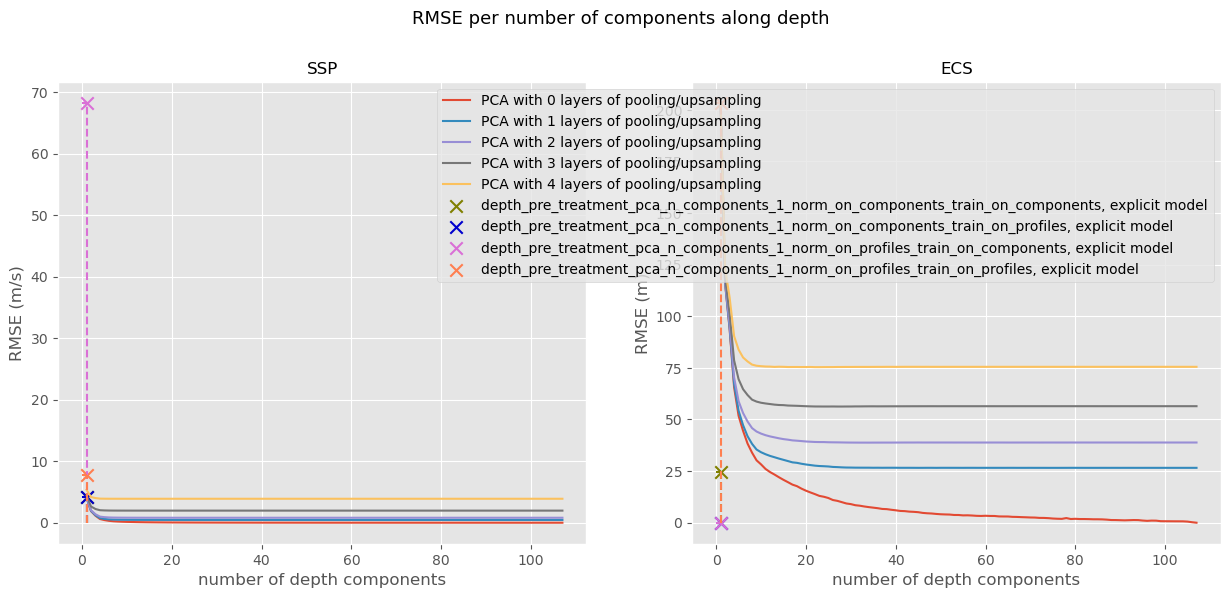

In [32]:

colors = ['olive', 'mediumblue', 'orchid', 'coral',
          'tomato','lightskyblue', 'mediumseagreen',
          'orange','yellowgreen', 'deepskyblue', 'navy', 
          'gold', 'dodgerblue', 'royalblue', 
          ]

fig,axs = plt.subplots(1,2,figsize=(15,6))



for n in range(pca_n_layers):

    if pca_n_layers == 1:
        label = "PCA"
    else:
        label = f"PCA with {n} layers of pooling/upsampling"

    axs[0].plot(pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), label = label)
    axs[1].plot(pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), label = label)

i = 0

for model in components_sorted_ae_rmse_dict["SSP"].keys():
        
    
    if len(components_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(components_sorted_ae_rmse_dict["SSP"][model][0], components_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(components_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(components_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, explicit model")  # s adjusts the cross size
        axs[1].hlines(components_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(components_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i = i+1     
        
    

            
        if filtering:
            
            axs[0].scatter(components_sorted_ae_rmse_dict["Filtered SSP"][model][0], components_sorted_ae_rmse_dict["Filtered SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model} filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[0].hlines(components_sorted_ae_rmse_dict["Filtered SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["Filtered SSP"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(components_sorted_ae_rmse_dict["Filtered SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["Filtered SSP"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(components_sorted_ae_rmse_dict["Filtered ECS"][model][0], components_sorted_ae_rmse_dict["Filtered ECS"][model][1], color=colors[i+2], marker='x', s=80, label = f"{model}, filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[1].hlines(components_sorted_ae_rmse_dict["Filtered ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["Filtered ECS"][model][0], colors=colors[i],linestyles='dashed')
            axs[1].vlines(components_sorted_ae_rmse_dict["Filtered ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["Filtered ECS"][model][1], colors=colors[i],linestyles='dashed')  
            
            i=i+1
               
             
    
    else:

        axs[0].plot(components_sorted_ae_rmse_dict["SSP"][model][0],components_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model} ")

        i=i+1
        
        if filtering:
                 
            axs[0].plot(components_sorted_ae_rmse_dict["Filtered SSP"][model][0],components_sorted_ae_rmse_dict["Filtered SSP"][model][1], c = colors[i], label = f"{model} filtered, kernel={best_median_kernel}")
            axs[1].plot(components_sorted_ae_rmse_dict["Filtered ECS"][model][0],components_sorted_ae_rmse_dict["Filtered ECS"][model][1], c = colors[i], label = f"{model}, filtered: kernel={best_median_kernel}")
            
            i=i+1
            




if norm:
    axs[0].set_ylabel("RMSE (normalized)")  
else:    
    axs[0].set_ylabel("RMSE (m/s)")  

axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper right", prop={'size': 8})    
    
if norm: 
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
else:   
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 8
elif len(labels) > 5:
    legend_fontsize = 10
else:
    legend_fontsize = 13

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:
    ax.set_xlabel("number of depth components")
    


    
fig_title = f"RMSE per number of components along depth"
fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    
    if filtering:
        save_name = save_name + f"_median_filter_kernel_{best_median_kernel}"
    
    if ecs_max:
        save_name = save_name + f"_ecs_max"
        
    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [33]:
pca_cr_dict = {}
for model in pca_rmse_dict["bottleneck_shape"].keys():
    reduced_lat,reduced_lon = pca_rmse_dict["bottleneck_shape"][model][-2:]
    spatial_cr = dm.test_shape[2]*dm.test_shape[3]/(reduced_lat*reduced_lon)
    pca_cr_dict[model] = [spatial_cr*dm.test_shape[1]/n for n in range(1,dm.test_shape[1]+1)] 


In [34]:

cr_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    cr_key_dict = {np.prod(dm.test_shape)/key.numel(): key for key in ae_rmse_dict["SSP"][model].keys()}
    sorted_cr_key = sorted(cr_key_dict.keys())
    
    # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    # sorted_components = [key[2] for key in sorted_keys]
    cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
     
    if filtering:
        cr_sorted_ae_rmse_dict["Filtered SSP"][model] = (sorted_cr_key, [ae_rmse_dict["Filtered SSP"][model][cr_key_dict[key]]  for key in sorted_cr_key])
        cr_sorted_ae_rmse_dict["Filtered ECS"][model] = (sorted_cr_key, [ae_rmse_dict["Filtered ECS"][model][cr_key_dict[key]]  for key in sorted_cr_key])
        


0
depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components
1
depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles
2
depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_components
3
depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles


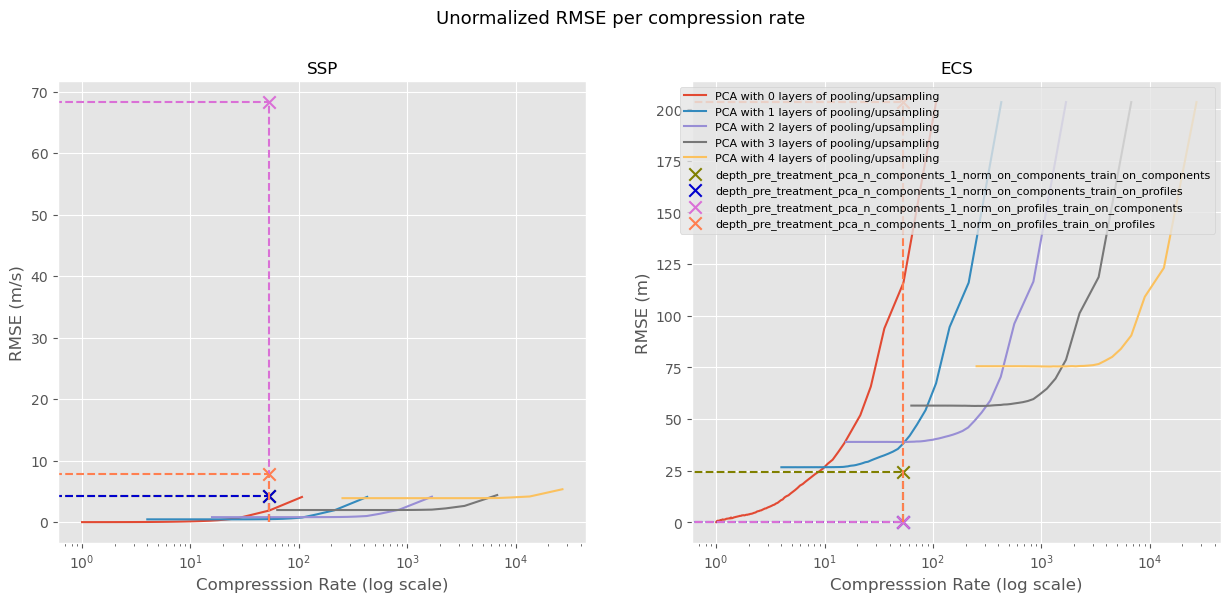

In [35]:
ecs_max = False
filtering = False

colors = ['olive', 'mediumblue', 'orchid', 'coral',
            'gold','lightskyblue', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 'navy', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,axs = plt.subplots(1,2,figsize=(15,6))


for n in range(pca_n_layers):
    if pca_n_layers == 1:
        label = "PCA"
    else:
        label = f"PCA with {n} layers of pooling/upsampling"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), label = label)

i = 0

for model in cr_sorted_ae_rmse_dict["SSP"].keys():
    
    print(i)
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            
        if filtering:
            
            axs[0].scatter(cr_sorted_ae_rmse_dict["Filtered SSP"][model][0], cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model} filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[0].hlines(cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["Filtered SSP"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(cr_sorted_ae_rmse_dict["Filtered SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(cr_sorted_ae_rmse_dict["Filtered ECS"][model][0], cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[1].hlines(cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["Filtered ECS"][model][0], colors=colors[i],linestyles='dashed')
            axs[1].vlines(cr_sorted_ae_rmse_dict["Filtered ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], colors=colors[i],linestyles='dashed')  
            
            i=i+1
            

    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model}")

        i=i+1
        
        
        if ecs_max:
            axs[1].plot(cr_sorted_ae_rmse_dict["ECS max"][model][0], cr_sorted_ae_rmse_dict["ECS max"][model][1], c = colors[i], label = f"{model} max algo")

            i=i+1
            
            
        if filtering:
            axs[0].plot(cr_sorted_ae_rmse_dict["Filtered SSP"][model][0],cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], c = colors[i], label = f"{model} filtered, kernel={best_median_kernel}")
            axs[1].plot(cr_sorted_ae_rmse_dict["Filtered ECS"][model][0],cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], c = colors[i], label = f"{model}, filtered: kernel={best_median_kernel}")
            
            i=i+1
            
            if ecs_max:
                axs[1].plot(cr_sorted_ae_rmse_dict["Filtered ECS max"][model][0],cr_sorted_ae_rmse_dict["Filtered ECS max"][model][1], c = colors[i], label = f"{model} max algo, filtered: kernel={best_median_kernel}")
                
                i=i+1
                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    


if norm: 
    axs[0].set_ylabel("RMSE")  
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Normalized RMSE per compression rate"
    
else:   
    axs[0].set_ylabel("RMSE (m/s)")  
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Unormalized RMSE per compression rate"


    # Adjust the legend size based on the number of labels
    handles, labels = axs[1].get_legend_handles_labels()
    if len(labels) > 10:
        legend_fontsize = 7
    elif len(labels) > 5:
        legend_fontsize = 8
    else:
        legend_fontsize = 10

    axs[1].legend(prop={'size': legend_fontsize})
            
for ax in axs:

    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    
    if filtering:
        save_name = save_name + f"_median_filter_kernel_{best_median_kernel}"
    
    if ecs_max:
        save_name = save_name + f"_ecs_max"
        
    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [36]:
cr_sorted_ae_rmse_dict

{'SSP': {'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components': ([53.5],
   [4.246218432328859]),
  'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles': ([53.5],
   [4.246219735206265]),
  'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_components': ([53.5],
   [68.28023121065887]),
  'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles': ([53.5],
   [7.764603918146666])},
 'ECS': {'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_components': ([53.5],
   [24.353290762959872]),
  'depth_pre_treatment_pca_n_components_1_norm_on_components_train_on_profiles': ([53.5],
   [0.0]),
  'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_components': ([53.5],
   [0.0]),
  'depth_pre_treatment_pca_n_components_1_norm_on_profiles_train_on_profiles': ([53.5],
   [203.4343441048063])},
 'Filtered SSP': {},
 'Filtered ECS': {},
 'ECS max': {},
 'Filtered ECS max': {}}